# 4. Bagging algorithms

This notebook will show different examples of bagging algorithms: Bagging, Random Forest and Extra-Trees.
The dataset used for them is [Rain in Australia](https://www.kaggle.com/jsphyg/weather-dataset-rattle-package) challenge from Kaggle. It contains about 10 years of daily weather observations from many locations across Australia.

### Index:
1. [Packages required](#1.-Packages-required)
2. [Loading data](#2.-Loading-data)
3. [Bagging](#3.-Bagging)
4. [Random Forest](#4.-Random-Forest)
5. [Extra-Trees](#5.-Extra-Trees)
6. [Conclusions](#6.-Conclusions)

# 1. Packages required

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import time

# 2. Loading data

In [2]:
weather = pd.read_parquet('../data/04_model_input/master.parquet')
weather.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Location.Walpole,Location.Hobart,Location.Launceston,Location.AliceSprings,Location.Darwin,Location.Katherine,Location.Uluru,WindGustDir_encoded,WindDir9am_encoded,WindDir3pm_encoded
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,0,0,0,0,0,0,0,12.0,12.0,13.0
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,0,0,0,0,0,0,0,13.0,15.0,11.0
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,0,0,0,0,0,0,0,11.0,12.0,11.0
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,0,0,0,0,0,0,0,2.0,6.0,4.0
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,0,0,0,0,0,0,0,12.0,3.0,14.0


# 3. Bagging

Bagging algorithm works taking training data samples and building different decision trees with each sample. The result of the algorithm is the mean of trees predictions or the most voted class (regresion or classification).

We are interested in running Bagging algorithm on the current dataset and show the results. We will choose train/test data according to an Out-Of-Time validation, with the purpose of knowing how well it works when it has to predict future 'RainTomorrow' values.

Also, we will test it with different numbers of samples and using Decision trees with max_depth = 5, the most efficient value as we can see in the last notebook.

In [3]:
#We fix the variables we are interested in and the date to separate data:
test_date = '2015-01-01'

model_columns = list(set(weather.select_dtypes(include='number').columns) - set(['RainTomorrow']))

In [4]:
#We separate in train/test data and solve Nan problems:
train = weather[weather.Date < test_date].fillna(-1)
test = weather[weather.Date >= test_date].fillna(-1)

In [5]:
#We generate our Bagging algorithms:
tree = DecisionTreeClassifier(max_depth = 5)
metrics = {}
for n_estimators in [1, 3, 5, 10, 15, 20, 30, 50, 100, 200, 500, 1000]:
    start_time = time.time()
    model = BaggingClassifier(base_estimator = tree, n_estimators = n_estimators)
    model.fit(train[model_columns],train.RainTomorrow);
    
    train_pred = model.predict_proba(train[model_columns])[:, 1]
    test_pred = model.predict_proba(test[model_columns])[:, 1]

    metrics['Bag_'+ str(n_estimators)] = {
        'Train_Gini': 2*roc_auc_score(train.RainTomorrow, train_pred)-1,
        'Test_Gini': 2*roc_auc_score(test.RainTomorrow, test_pred)-1,
        'Run_Time': time.time() - start_time
    }

metrics_bag = pd.DataFrame.from_dict(metrics, orient='index',columns=['Run_Time', 'Train_Gini', 'Test_Gini'])
metrics_bag['delta%'] = 100*(metrics_bag.Test_Gini - metrics_bag.Train_Gini) / metrics_bag.Train_Gini
metrics_bag

,Run_Time,Train_Gini,Test_Gini,delta%
Bag_1,0.569756,0.652804,0.626125,-4.086840
Bag_3,1.396432,0.686066,0.662261,-3.469762
Bag_5,2.430809,0.685229,0.658250,-3.937209
Bag_10,4.579969,0.694631,0.669869,-3.564762
Bag_15,6.394330,0.690684,0.660509,-4.368865
Bag_20,8.439155,0.692359,0.667660,-3.567320
Bag_30,12.639145,0.693983,0.668716,-3.640867
Bag_50,20.978450,0.694237,0.669650,-3.541666
Bag_100,41.666368,0.695090,0.669732,-3.648175
Bag_200,83.036963,0.695760,0.671176,-3.533289


In [6]:
metrics_bag.to_parquet('../data/models/bag.parquet')

# 4. Random Forest

Random Forest algorithm works as Bagging but taking features samples too. The most common number of features is $\sqrt{p}$, where p is the total number of features. So, Random Forest build trees with different rows and different columns and the prediction is the mean of trees predictions or the most voted class (regression or classification).

Now, we are interested in running Random Forest algorithm on the current dataset to know 'RainTomorrow' predictions. We will choose validation data according to the last example. Also, we will compare its efectiveness with different numbers of samples and we will use a Decision tree with max_depth = 5 as base estimator.

In [7]:
#We generate our Random Forest algorithms:
metrics = {}
for n_estimators in [1, 3, 5, 10, 15, 20, 30, 50, 100, 200, 500, 1000]:
    start_time = time.time()
    model = RandomForestClassifier(n_estimators = n_estimators, max_depth = 5, max_features = 'sqrt')
    model.fit(train[model_columns],train.RainTomorrow);
    
    train_pred = model.predict_proba(train[model_columns])[:, 1]
    test_pred = model.predict_proba(test[model_columns])[:, 1]

    metrics['RF_'+ str(n_estimators)] = {
        'Train_Gini': 2*roc_auc_score(train.RainTomorrow, train_pred)-1,
        'Test_Gini': 2*roc_auc_score(test.RainTomorrow, test_pred)-1,
        'Run_Time': time.time() - start_time
    }

metrics_RF = pd.DataFrame.from_dict(metrics, orient='index',columns=['Run_Time', 'Train_Gini', 'Test_Gini'])
metrics_RF['delta%'] = 100*(metrics_RF.Test_Gini - metrics_RF.Train_Gini) / metrics_RF.Train_Gini
metrics_RF

,Run_Time,Train_Gini,Test_Gini,delta%
RF_1,0.235238,0.491650,0.464036,-5.616646
RF_3,0.325913,0.655354,0.620836,-5.267100
RF_5,0.485373,0.651573,0.624853,-4.100843
RF_10,0.820284,0.679899,0.651358,-4.197942
RF_15,1.001081,0.680212,0.656313,-3.513428
RF_20,1.314684,0.691660,0.666464,-3.642840
RF_30,2.065816,0.691248,0.667620,-3.418141
RF_50,3.290054,0.698103,0.671777,-3.771100
RF_100,6.353807,0.695091,0.671622,-3.376352
RF_200,11.663415,0.698434,0.673851,-3.519678


In [8]:
metrics_RF.to_parquet('../data/models/rf.parquet')

# 5. Extra-Trees

Extra-Trees is based on Random Forest. The difference between them is in the way to build the trees: Random Forest separate nodes according to the most efficient partition and Extra Trees fix a random value for each variable and separate nodes according to this random values. Thus, it grants more randomness to the algorithm.

We will repeat the objective: evaluate 'RainTomorrow' predictions that it offers, using Out-Of-Time validation and trees with max_depth = 5.

In [9]:
#We generate our Extra-Trees algorithms:
metrics = {}
for n_estimators in [1, 3, 5, 10, 15, 20, 30, 50, 100, 200, 500, 1000]:
    start_time = time.time()
    model = ExtraTreesClassifier(n_estimators = n_estimators, max_depth = 5, max_features = 'sqrt')
    model.fit(train[model_columns],train.RainTomorrow);
    
    train_pred = model.predict_proba(train[model_columns])[:, 1]
    test_pred = model.predict_proba(test[model_columns])[:, 1]

    metrics['ET_'+ str(n_estimators)] = {
        'Train_Gini': 2*roc_auc_score(train.RainTomorrow, train_pred)-1,
        'Test_Gini': 2*roc_auc_score(test.RainTomorrow, test_pred)-1,
        'Run_Time': time.time() - start_time
    }

metrics_ET = pd.DataFrame.from_dict(metrics, orient='index',columns=['Run_Time', 'Train_Gini', 'Test_Gini'])
metrics_ET['delta%'] = 100*(metrics_ET.Test_Gini - metrics_ET.Train_Gini) / metrics_ET.Train_Gini
metrics_ET

,Run_Time,Train_Gini,Test_Gini,delta%
ET_1,0.193452,0.301142,0.263115,-12.627520
ET_3,0.258815,0.560588,0.545684,-2.658604
ET_5,0.357301,0.601546,0.580637,-3.475881
ET_10,0.564833,0.656964,0.635055,-3.334935
ET_15,0.763662,0.657134,0.629199,-4.251036
ET_20,0.936003,0.643101,0.618421,-3.837653
ET_30,1.261580,0.646842,0.619240,-4.267159
ET_50,1.968970,0.652797,0.629336,-3.593893
ET_100,3.845135,0.652666,0.629375,-3.568689
ET_200,7.509160,0.655881,0.631665,-3.692161


In [10]:
metrics_ET.to_parquet('../data/models/et.parquet')

# 6. Conclusions

As we can see, using bagging algorithms is a good way to reduce variance and avoid overfitting. Comparing the results with the Decision Tree example, with max_depth = 5 we had:

Train_Gini = 0.655905

Test_Gini = 0.626416

delta% = -4.496019

Comparing with our new results, all of these indicators are improved with any of the methods explained in this notebook.

Also, we will show that the number of estimators is not relevant. As we can see, in bagging methods, Gini coefficient converges. Thus, there's no reason to generate lots of estimators, because we won't increase the model's accuracy.

<AxesSubplot:title={'center':'Conjunto de testeo'}, xlabel='Número de árboles', ylabel='Gini'>

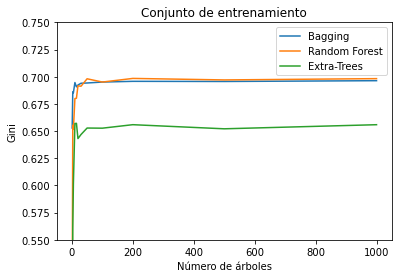

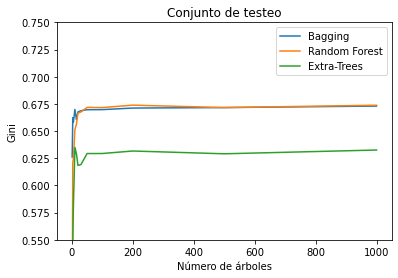

In [11]:
GINITRAIN = pd.DataFrame({'Bagging': list(metrics_bag.Train_Gini.values),
              'Random Forest': list(metrics_RF.Train_Gini.values), 
              'Extra-Trees': list(metrics_ET.Train_Gini.values)}, index = [1, 3, 5, 10, 15, 20, 30, 50, 100, 200, 500, 1000])

GINITEST = pd.DataFrame({'Bagging': list(metrics_bag.Test_Gini.values),
              'Random Forest': list(metrics_RF.Test_Gini.values), 
              'Extra-Trees': list(metrics_ET.Test_Gini.values)}, index = [1, 3, 5, 10, 15, 20, 30, 50, 100, 200, 500, 1000])

GINITRAIN.plot(ylim = [0.55,0.75], xlabel = 'Número de árboles', ylabel = 'Gini', title = 'Conjunto de entrenamiento')
GINITEST.plot(ylim = [0.55,0.75], xlabel = 'Número de árboles', ylabel = 'Gini', title = 'Conjunto de testeo')